# Compass.UOL - Sprint 4 & 5
## Equipe 3 - José Pedro, Pedro Montenegro, Natália Cardoso, Renan Mazzilli

## Dataset: [hotel_reservations](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)

## Treinamento dos modelos localmente para fins de comparações e testes

#### Posteriormente, o modelo escolhido a partir das melhores métricas será treinado no Sagemaker

### Imports e instalações necessárias

In [2]:
# Instalar as bibliotecas necessárias para o projeto
%pip install pandas boto3 joblib scikit-learn sagemaker seaborn

# Importar as bibliotecas necessárias
import os
import json
import boto3
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


### Configurações gerais do projeto e variáveis globais

In [3]:
# Carregar configurações do arquivo JSON
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Atribuir as variáveis de configuração
bucket_name = config['bucket_name']
table_name = config['table_name']
model_metrics_table = config['model_metrics_table']
role_name = config['role_name']
dataset_path = config['dataset_path']
processed_dataset_path = config['processed_dataset_path']
model_path = config['model_path']
profile_name = config['profile_name']
aws_region = config['aws_region']

# Inicialização da sessão AWS
session = boto3.Session(profile_name=profile_name, region_name=aws_region)
s3_client = session.client('s3')
dynamodb_client = session.client('dynamodb')
iam_client = session.client('iam')

### Treinamento local do modelo com algoritmo Random Forest 

Cross-validation scores: [0.63492063 0.70899471 0.75       0.61702128 0.71276596]
Mean cross-validation score: 0.6847405155915794
Accuracy: 0.6910828025477707
Precision: 0.6913524079129175
Recall: 0.6910828025477707
F1 Score: 0.6909894908685713


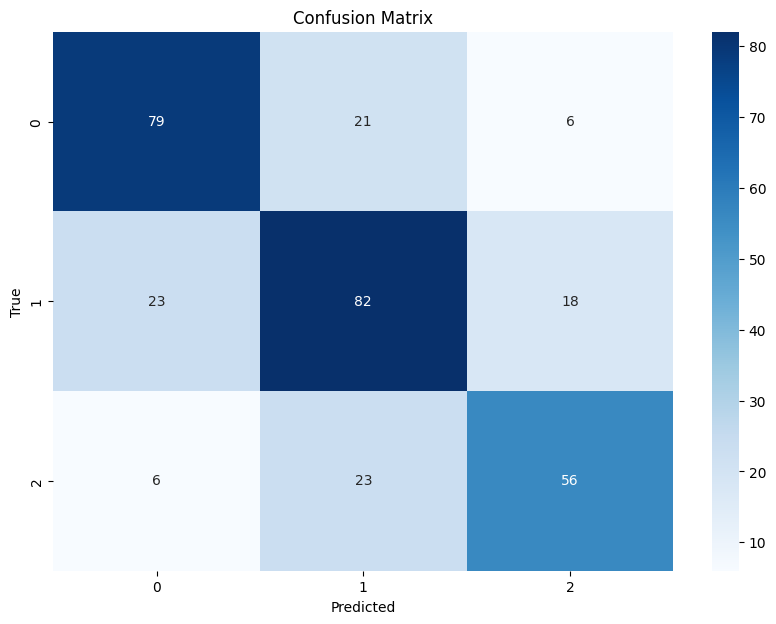

Cross-validation scores: [0.64021164 0.68783069 0.75531915 0.63297872 0.70744681]
Mean cross-validation score: 0.6847574017786784
Accuracy: 0.7070063694267515
Precision: 0.7105396583959185
Recall: 0.7070063694267515
F1 Score: 0.7075187641559619


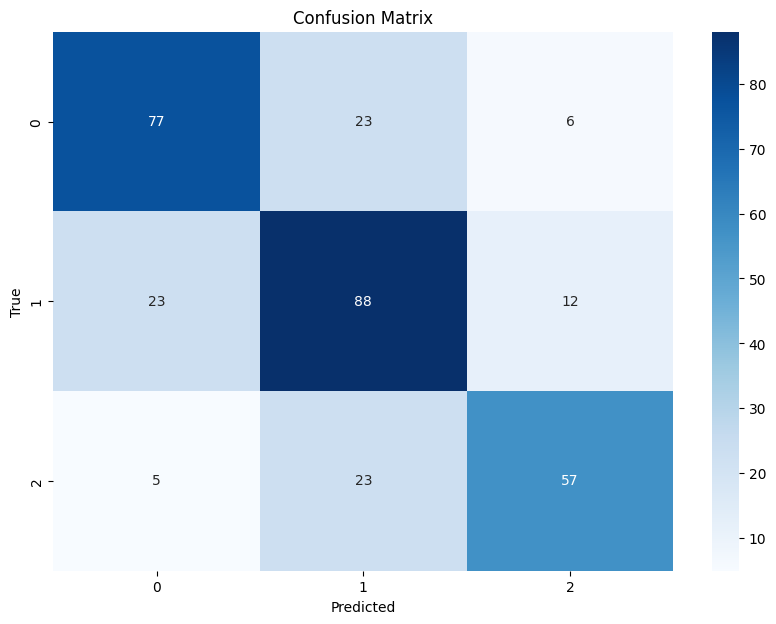

c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Cross-validation scores: [0.45502646 0.60846561 0.5        0.43617021 0.4893617 ]
Mean cross-validation score: 0.4978047956771361
Accuracy: 0.5382165605095541
Precision: 0.5409020942741348
Recall: 0.5382165605095541
F1 Score: 0.5362030454144978


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


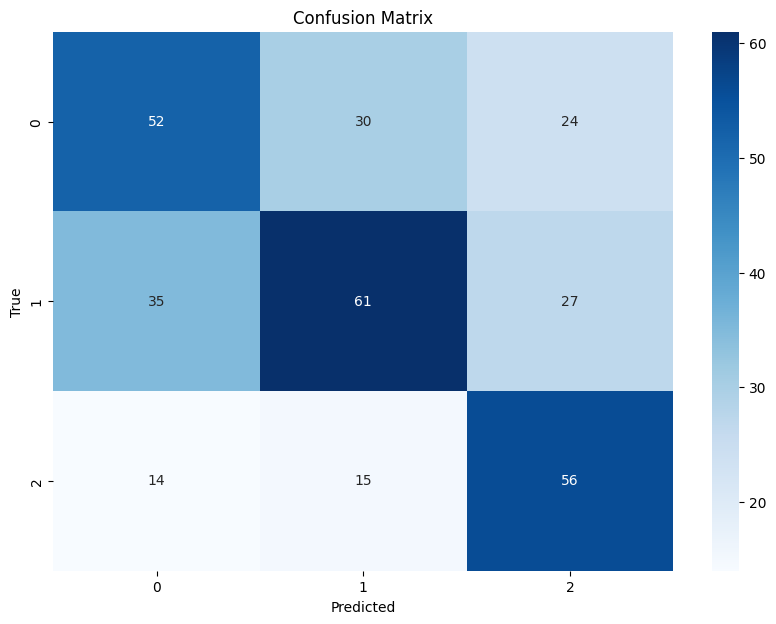

Cross-validation scores: [0.56613757 0.6031746  0.62234043 0.55319149 0.62234043]
Mean cross-validation score: 0.5934369019475403
Accuracy: 0.5955414012738853
Precision: 0.5949866254033371
Recall: 0.5955414012738853
F1 Score: 0.5950298083131025


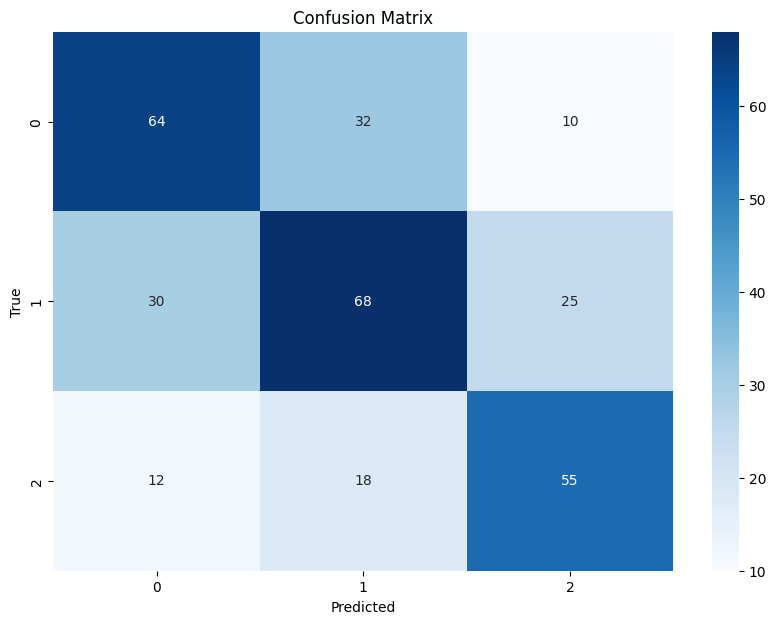

Cross-validation scores: [0.64550265 0.6984127  0.71808511 0.60638298 0.68617021]
Mean cross-validation score: 0.6709107283575368
Accuracy: 0.6592356687898089
Precision: 0.6608431709705256
Recall: 0.6592356687898089
F1 Score: 0.6597969503956764


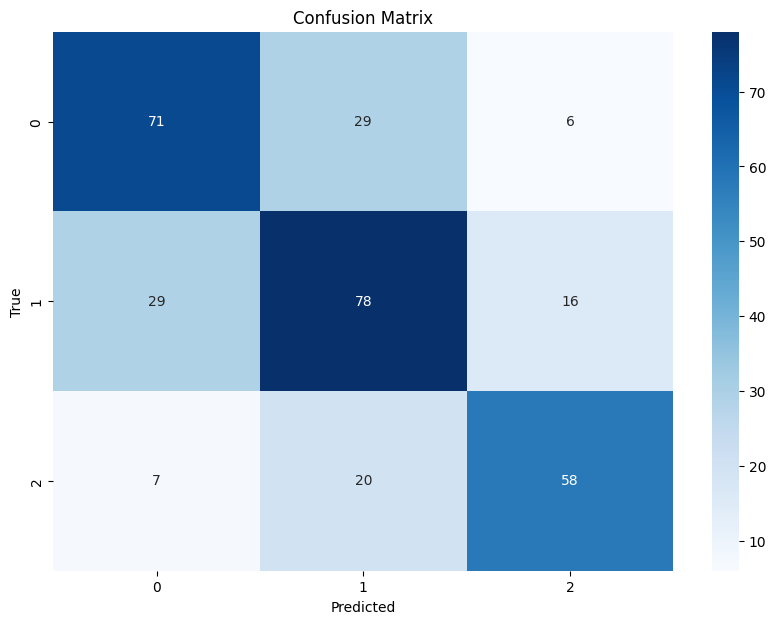

Cross-validation scores: [0.38624339 0.38095238 0.37765957 0.37765957 0.37234043]
Mean cross-validation score: 0.37897106833277044
Accuracy: 0.37579617834394907
Precision: 0.23075187376455086
Recall: 0.37579617834394907
F1 Score: 0.27142287824942485


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


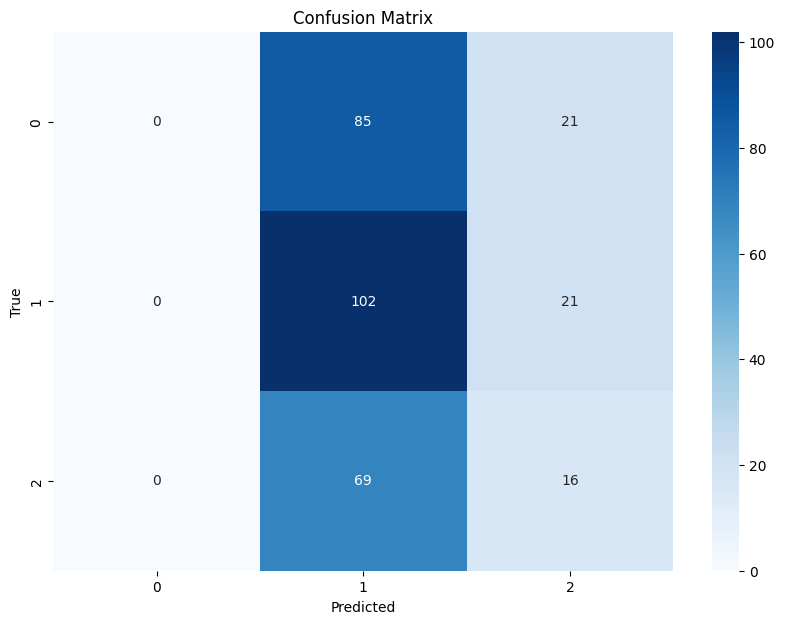

Cross-validation scores: [0.37566138 0.37037037 0.31382979 0.30851064 0.39361702]
Mean cross-validation score: 0.35239783856805135
Accuracy: 0.3980891719745223
Precision: 0.7627082312591866
Recall: 0.3980891719745223
F1 Score: 0.23412953276088103


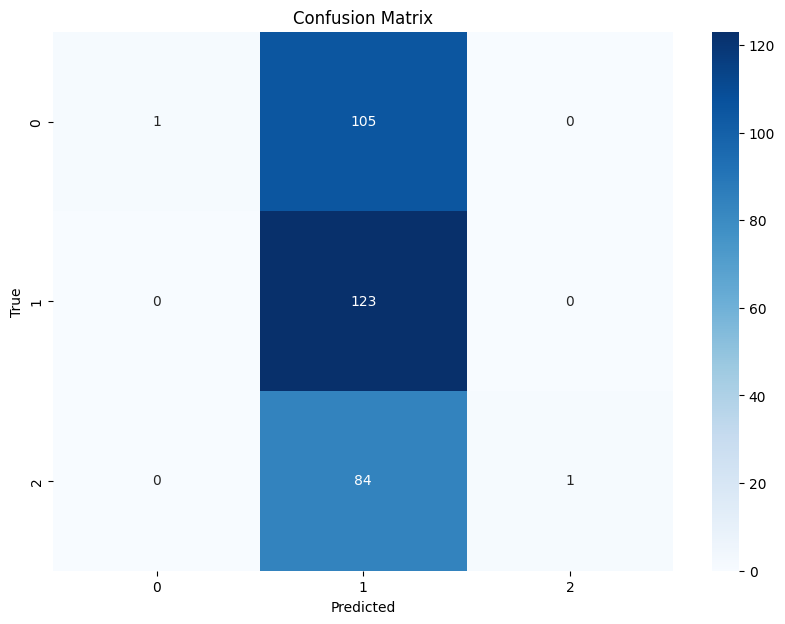

In [35]:
# Classe para treinamento do modelo
class ModelTrainer:
    def __init__(self, table_name, bucket_name, model_path, profile_name):
        self.table_name = table_name
        self.bucket_name = bucket_name
        self.model_path = model_path
        self.session = boto3.Session(profile_name=profile_name)
        self.dynamodb = self.session.resource('dynamodb')
        self.s3_client = self.session.client('s3')
    # Método para buscar os dados da tabela do DynamoDB
    def fetch_data_from_dynamodb(self):
        table = self.dynamodb.Table(self.table_name)
        response = table.scan()
        self.dataset = pd.DataFrame(response['Items'])
    # Método para preparar os dados para treinamento
    def prepare_data(self):
        self.dataset['label_avg_price_per_room'] = self.dataset['label_avg_price_per_room'].astype(int)
        X = self.dataset.drop(columns=['label_avg_price_per_room'])
        y = self.dataset['label_avg_price_per_room']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # Método para treinar o modelo e avaliar as métricas
    def train_model(self):
        self.model = RandomForestClassifier()

        # Validação Cruzada
        scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='accuracy')
        print("Cross-validation scores:", scores)
        print("Mean cross-validation score:", scores.mean())

        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        self.accuracy = accuracy_score(self.y_test, y_pred)
        self.precision = precision_score(self.y_test, y_pred, average='weighted')
        self.recall = recall_score(self.y_test, y_pred, average='weighted')
        self.f1 = f1_score(self.y_test, y_pred, average='weighted')

        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 Score:", self.f1)

        # Matriz de confusão
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# Executar o treinamento do modelo e obter as métricas
trainer = ModelTrainer(table_name, bucket_name, model_path, profile_name)
trainer.fetch_data_from_dynamodb()
trainer.prepare_data()
trainer.train_model()


Accuracy: 0.8133521391631405
Precision: 0.813766736481474
Recall: 0.8133521391631405
F1 Score: 0.8134187468152695


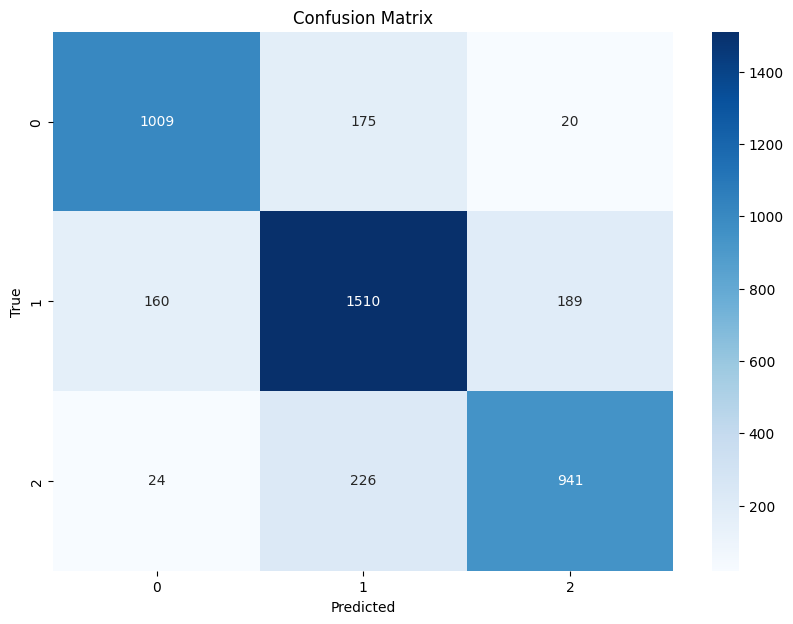

In [8]:
# Classe para treinamento do modelo com o al
class ModelTrainer:
    def __init__(self, table_name, bucket_name, model_path, profile_name):
        pass

    def prepare_data(self):
        # Carregar os dados preprocessados localmente
        self.dataset = pd.read_csv(processed_dataset_path)

        self.dataset['label_avg_price_per_room'] = self.dataset['label_avg_price_per_room'].astype(int)
        X = self.dataset.drop(columns=['label_avg_price_per_room'])
        y = self.dataset['label_avg_price_per_room']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)


    def train_model(self):
        # Carregar os dados preprocessados localmente
        self.dataset = pd.read_csv(processed_dataset_path)

        # Preparar dados para treinamento
        self.dataset['label_avg_price_per_room'] = self.dataset['label_avg_price_per_room'].astype(int)
        X = self.dataset.drop(columns=['label_avg_price_per_room'])
        y = self.dataset['label_avg_price_per_room']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Treinar o modelo Random Forest Classifier
        self.model = RandomForestClassifier()
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        # Calcular métricas de avaliação
        self.accuracy = accuracy_score(self.y_test, y_pred)
        self.precision = precision_score(self.y_test, y_pred, average='weighted')
        self.recall = recall_score(self.y_test, y_pred, average='weighted')
        self.f1 = f1_score(self.y_test, y_pred, average='weighted')

        # Imprimir métricas de avaliação
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 Score:", self.f1)

        # Matriz de confusão do modelo
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix - Random Forest Classifier')
        plt.show()

# Executar o treinamento e upload do modelo para o S3
trainer = ModelTrainer(table_name, bucket_name, model_path, profile_name)
trainer.prepare_data()
trainer.train_model()

Accuracy: 0.8309826046074283
Precision: 0.8312666942936298
Recall: 0.8309826046074283
F1 Score: 0.8310718854058423


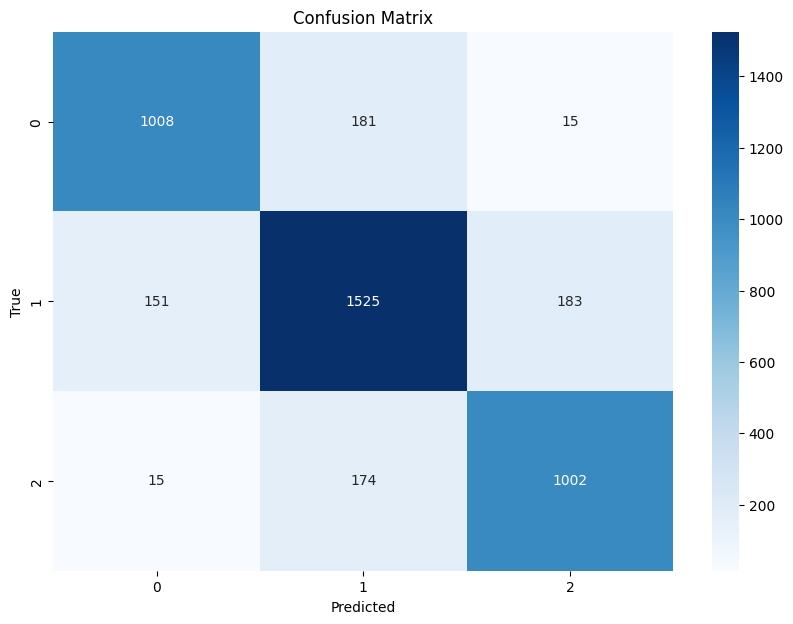

In [9]:
# Classe para treinamento do modelo
class ModelTrainer:
    def __init__(self, table_name, bucket_name, model_path, profile_name):
        pass
        
    def prepare_data(self):
        # Carregar os dados preprocessados localmente
        self.dataset = pd.read_csv(processed_dataset_path)

        # Ajustar as classes da variável alvo
        self.dataset['label_avg_price_per_room'] = self.dataset['label_avg_price_per_room'] - 1

        X = self.dataset.drop(columns=['label_avg_price_per_room'])
        y = self.dataset['label_avg_price_per_room']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)


    def train_model(self):
        # Carregar os dados preprocessados localmente
        self.dataset = pd.read_csv(processed_dataset_path)

        # Ajustar as classes da variável alvo
        self.dataset['label_avg_price_per_room'] = self.dataset['label_avg_price_per_room'] - 1

        X = self.dataset.drop(columns=['label_avg_price_per_room'])
        y = self.dataset['label_avg_price_per_room']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Treinar o modelo XGBoost Classifier localmente
        self.model = XGBClassifier() 
        self.model.fit(self.X_train, self.y_train)
        y_pred = self.model.predict(self.X_test)

        # Calcular métricas
        self.accuracy = accuracy_score(self.y_test, y_pred)
        self.precision = precision_score(self.y_test, y_pred, average='weighted')
        self.recall = recall_score(self.y_test, y_pred, average='weighted')
        self.f1 = f1_score(self.y_test, y_pred, average='weighted')

        # Imprimir métricas
        print("Accuracy:", self.accuracy)
        print("Precision:", self.precision)
        print("Recall:", self.recall)
        print("F1 Score:", self.f1)

        # Matriz de confusão
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# Executar o treinamento e upload do modelo para o S3
trainer = ModelTrainer(table_name, bucket_name, model_path, profile_name)
trainer.prepare_data()
trainer.train_model()

### Com isso, o algoritmo XGBoost foi escolhido para ser utilizado no treinamento do modelo no Sagemaker e utilizado no projeto final devido a suas melhores métricas:

- Accuracy: 0.8309826046074283 (que é a taxa de verdadeiros positivos e verdadeiros negativos sobre o total de elementos)

- Precision: 0.8312666942936298 (que é a taxa de verdadeiros positivos sobre a soma de verdadeiros positivos e falsos positivos)

- Recall: 0.8309826046074283 (que é a taxa de verdadeiros positivos)

- F1 Score: 0.8310718854058423 (que é a média harmônica entre Precision e Recall)